# Random Forest Algorithm

#### Importación de librerías ⬇️

In [16]:
import pickle
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import export_text, plot_tree
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import seaborn as sns

In [17]:
# Importar data de un csv
data = pd.read_csv('los_data_gt.csv')
df = data.copy()
data

,dias_estancia,sexo,grupo_etnico,departamento,municipio,causa_atencion,condicion_egreso,tratamiento_recibido,edad_correcta,causa_categoria,edad_categoria,region
0,1.0,Hombre,Ignorado,Guatemala,San Juan Sacatepéquez,P95X,Vivo,Médico,0.000000,Certain conditions originating in the perinata...,Primera Infancia,Central
1,1.0,Mujer,Ignorado,Zacapa,Zacapa,P95X,Vivo,Médico,0.000000,Certain conditions originating in the perinata...,Primera Infancia,Nororiente
2,2.0,Mujer,No indígena,Quetzaltenango,Quetzaltenango,P95X,Vivo,Médico,0.000000,Certain conditions originating in the perinata...,Primera Infancia,Occidente
3,2.0,Mujer,No indígena,Quetzaltenango,Quetzaltenango,P95X,Vivo,Médico,0.000000,Certain conditions originating in the perinata...,Primera Infancia,Occidente
4,2.0,Mujer,No indígena,Quetzaltenango,Quetzaltenango,P95X,Vivo,Médico,0.000000,Certain conditions originating in the perinata...,Primera Infancia,Occidente
...,...,...,...,...,...,...,...,...,...,...,...,...
2228323,1.0,Mujer,"Mestizo, Ladino",Extranjero,Extranjero,O829,Vivo,Obstétrico,33.000000,"Pregnancy, childbirth and the puerperium",Adulto,Central
2228324,1.0,Mujer,"Mestizo, Ladino",Extranjero,Extranjero,O829,Vivo,Obstétrico,34.000000,"Pregnancy, childbirth and the puerperium",Adulto,Central
2228325,2.0,Mujer,"Mestizo, Ladino",Extranjero,Extranjero,O829,Vivo,Obstétrico,18.000000,"Pregnancy, childbirth and the puerperium",Adolescente,Central
2228326,3.0,Hombre,Maya,Guatemala,Guatemala,Z380,Vivo,Médico,0.008219,Factors influencing health status and contact ...,Primera Infancia,Central


# Preparaciones de la Data

In [18]:
df.pop('condicion_egreso')
df.pop('municipio')
df.pop('region')
df = df[df['departamento'] == 'Guatemala']
df.pop('departamento')

freqs = df['dias_estancia'].value_counts()
df = df.loc[df['dias_estancia'] <= 30]

# Filter out the rows where the frequency is not equal to 1
uniques = freqs[freqs == 1].index
df = df[~df['dias_estancia'].isin(uniques)]

# Define conditions for categorizing dias_estancia
conditions = [
    (df['dias_estancia'] < 5),
    (df['dias_estancia'] >= 5)
]

# Define labels for the categories
labels = [0, 1]

# Create a new column 'categoria_estancia' based on the conditions and labels
df['categoria_estancia'] = np.select(conditions, labels)

In [19]:
column_dtypes = df.dtypes

# Iterate through each column dtype and change dtype to "category" if it's "object"
for col_name, dtype in column_dtypes.items():
    if dtype == 'object':
        df[col_name] = df[col_name].astype('category')

df['categoria_estancia'] = df['categoria_estancia'].astype('category')

In [20]:
# Initialize the encoder
encoder = OrdinalEncoder()

# Reshape the input data to a 2-dimensional array
data = df[['causa_atencion']]  # Selecting only the column you want to encode
data = data.values.reshape(-1, 1)  # Reshape to a 2-dimensional array

# Fit and transform the encoder on the reshaped data
encoded_data = encoder.fit_transform(data)

# Assign the encoded data back to the DataFrame
df['causa_atencion'] = encoded_data

## Preparacion de las funciones de utilidad

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import time

def clfMetrics(clf, X_test, X_train, y_test, y_train):

    initTime = time.perf_counter()

    # Predecir en el conjunto de prueba
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    endTime = time.perf_counter()
    print(f"Se tardo {endTime - initTime} segundos en predecir")

    # Accuracy
    accuracy_test = accuracy_score(y_test, y_pred_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)

    # Precision
    precision_test = precision_score(y_test, y_pred_test, average='micro')
    precision_train = precision_score(y_train, y_pred_train, average='micro')

    # Recall
    recall_test = recall_score(y_test, y_pred_test, average='micro')
    recall_train = recall_score(y_train, y_pred_train, average='micro')

    # F1 Score
    f1_test = f1_score(y_test, y_pred_test, average='micro')
    f1_train = f1_score(y_train, y_pred_train, average='micro')

    # Confusion Matrix
    confusionMatrix_test = confusion_matrix(y_test, y_pred_test)
    confusionMatrix_train = confusion_matrix(y_train, y_pred_train)

    print("--------------------------------------------------------------")
    print("----------------------------TEST------------------------------")

    # Calcular las matrices de confusión con porcentaje
    total_samples_test = np.sum(confusionMatrix_test)
    confusionMatrix_percent_test = confusionMatrix_test / total_samples_test * 100

    # Inicializar ConfusionMatrixDisplay con la matriz de confusión
    cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix_test)

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plotting the confusion matrix
    cmDisplay.plot(ax=ax)
    plt.title('Matriz de Confusión de Modelo Clasificador')
    plt.show()

    # Inicializar ConfusionMatrixDisplay con la matriz de confusión porcentual
    cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix_percent_test)

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plotting the confusion matrix
    cmDisplay.plot(ax=ax)
    plt.title('Matriz de Confusión de Modelo Clasificador (Porcentaje)')
    plt.show()

    print(confusionMatrix_percent_test)

    print("Accuracy:", accuracy_test)
    print("Precision:", precision_test)
    print("Recall:", recall_test)
    print("F1 Score:", f1_test)

    print("--------------------------------------------------------------")
    print("----------------------------TRAIN------------------------------")

    # Calcular las matrices de confusión con porcentaje
    total_samples_train = np.sum(confusionMatrix_train)
    confusionMatrix_percent_train = confusionMatrix_train / total_samples_train * 100

    # Inicializar ConfusionMatrixDisplay con la matriz de confusión
    cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix_train)

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plotting the confusion matrix
    cmDisplay.plot(ax=ax)
    plt.title('Matriz de Confusión de Modelo Clasificador')
    plt.show()

    # Inicializar ConfusionMatrixDisplay con la matriz de confusión porcentual
    cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix_percent_train)

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plotting the confusion matrix
    cmDisplay.plot(ax=ax)
    plt.title('Matriz de Confusión de Modelo Clasificador (Porcentaje)')
    plt.show()

    print(confusionMatrix_percent_train)

    print("Accuracy:", accuracy_train)
    print("Precision:", precision_train)
    print("Recall:", recall_train)
    print("F1 Score:", f1_train)


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score


def classificationRandomForest(X_train, y_train, X_test, y_test):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 55, 40, 45, 30]
    }

    # Crear el modelo de Random Forest
    rf_model = RandomForestClassifier(random_state=42)

    # Crear el objeto GridSearchCV
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')

    # Entrenar el modelo
    grid_search.fit(X_train, y_train)

    # Obtener los mejores parámetros y el mejor estimador
    best_params = grid_search.best_params_
    print("Los mejores parametros", best_params)
    best_estimator = grid_search.best_estimator_

    clfMetrics(best_estimator,X_test,X_train , y_test,y_train)

    return best_estimator

### Preparar los modelos de regresion

In [23]:
dr = data.copy()

In [24]:
# Evaluación de variables
def change(variable, dictValue, df2):
    count = 1

    def changeToVariable(x):
        nonlocal count
        nonlocal dictValue
        if x in dictValue:
            return dictValue[x]
        else:
            dictValue[x] = count
            count += 1
            return dictValue[x]
        
    if not pd.api.types.is_numeric_dtype(df2[variable]):
        df2[variable] = df2[variable].apply(changeToVariable)


def chageNotNumericVars(df):
    dicVars = {}
    for col in df.columns:
        change(col, dicVars, df)
    return dicVars

### Entrenamiento de modelos de clasificación

In [25]:
df.columns

Index(['dias_estancia', 'sexo', 'grupo_etnico', 'causa_atencion',
       'tratamiento_recibido', 'edad_correcta', 'causa_categoria',
       'edad_categoria', 'categoria_estancia'],
      dtype='object')

In [29]:
# Usar el SOMTEEN
from imblearn.combine import SMOTEENN
# Crear una instancia de RandomUnderSampler
rus = SMOTEENN(random_state=42)

dfClassifier = df.copy()


In [30]:
dfClassifier.pop('causa_categoria')
dfClassifier.pop('dias_estancia')
dfClassifier.pop('edad_correcta')
0

0

In [31]:
y = dfClassifier.pop('categoria_estancia')
X = dfClassifier
otherVarsDict = chageNotNumericVars(X)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento: (952109, 5)
Tamaño del conjunto de prueba: (238028, 5)


In [85]:
# Hacer un Random Forest como clasificador
rfClass_model = RandomForestClassifier(random_state=42)
rfClass_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Se tardo 27.691172399994684 segundos en predecir
--------------------------------------------------------------
----------------------------TEST------------------------------


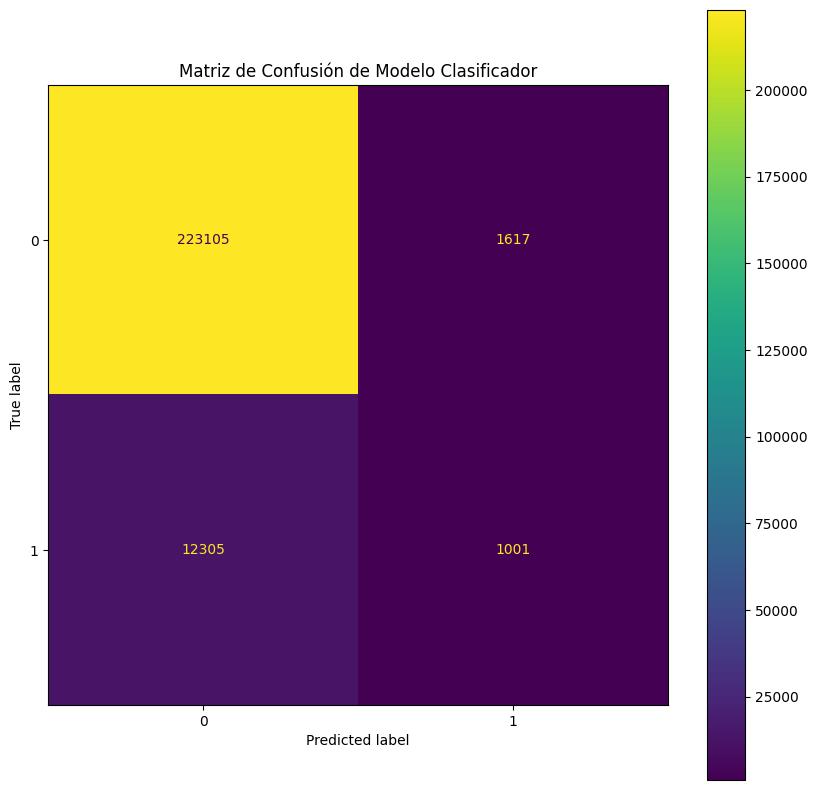

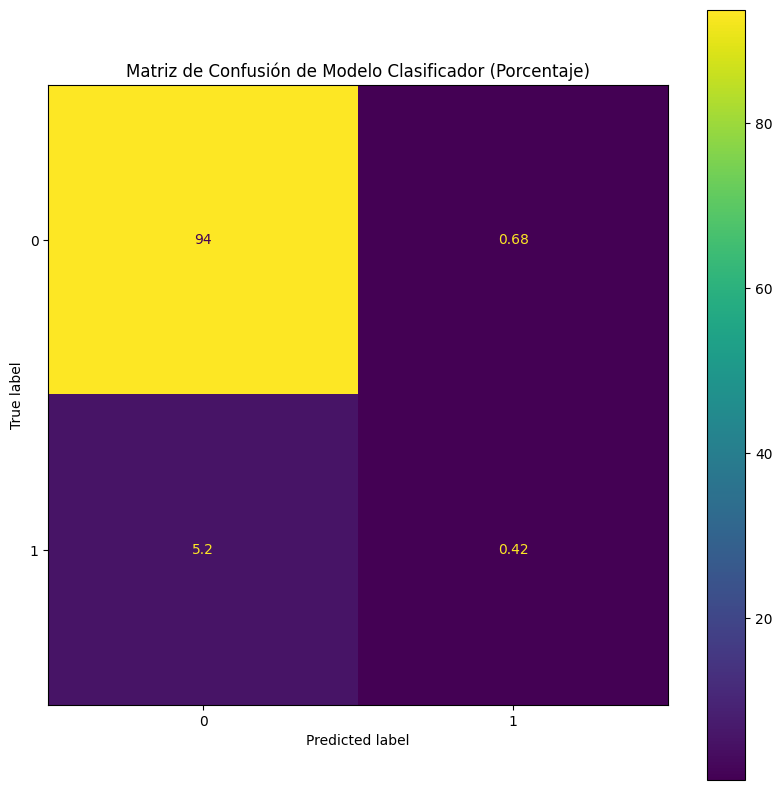

[[93.73056951  0.67933184]
 [ 5.16955988  0.42053876]]
Accuracy: 0.9415110827297629
Precision: 0.9415110827297629
Recall: 0.9415110827297629
F1 Score: 0.9415110827297629
--------------------------------------------------------------
----------------------------TRAIN------------------------------


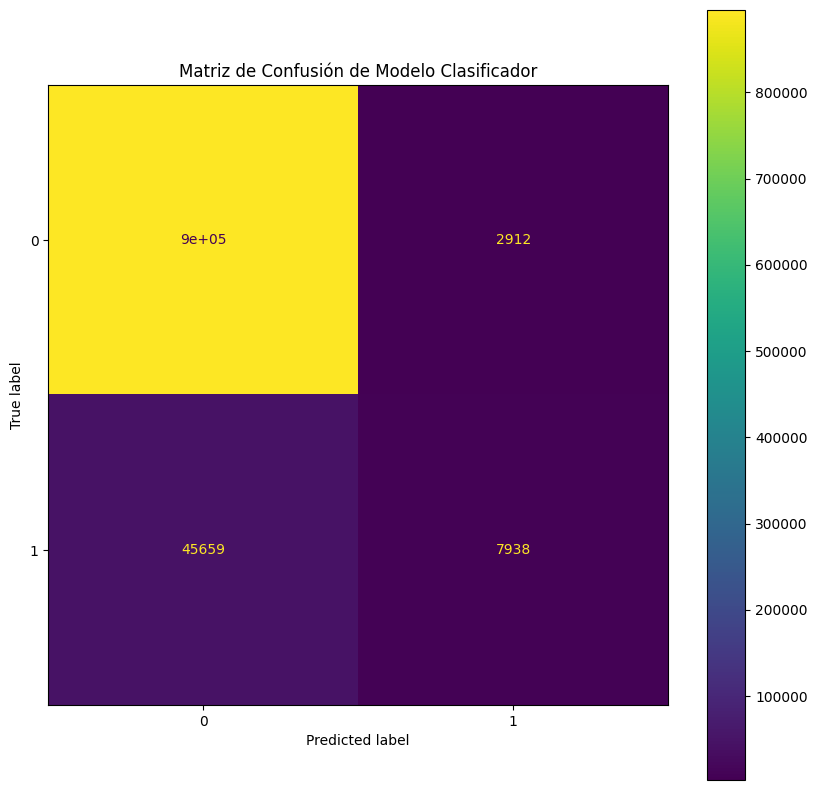

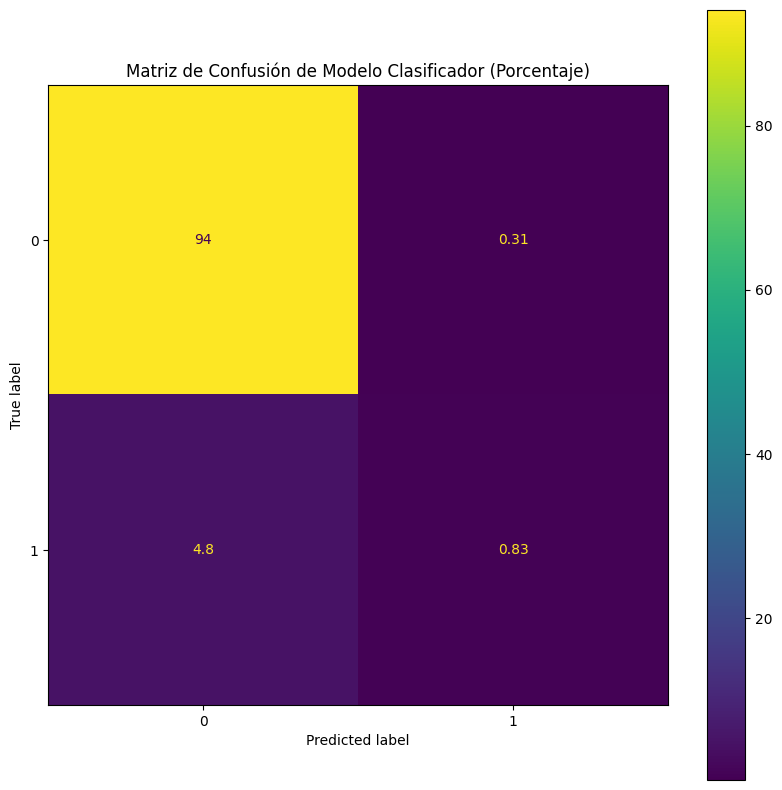

[[94.06486022  0.30584733]
 [ 4.79556437  0.83372807]]
Accuracy: 0.9489858829188674
Precision: 0.9489858829188674
Recall: 0.9489858829188674
F1 Score: 0.9489858829188674


In [86]:
clfMetrics(rfClass_model, X_test,X_train , y_test,y_train)

Los mejores parametros {'max_depth': 30, 'n_estimators': 300}
Se tardo 51.53395929999533 segundos en predecir
--------------------------------------------------------------
----------------------------TEST------------------------------


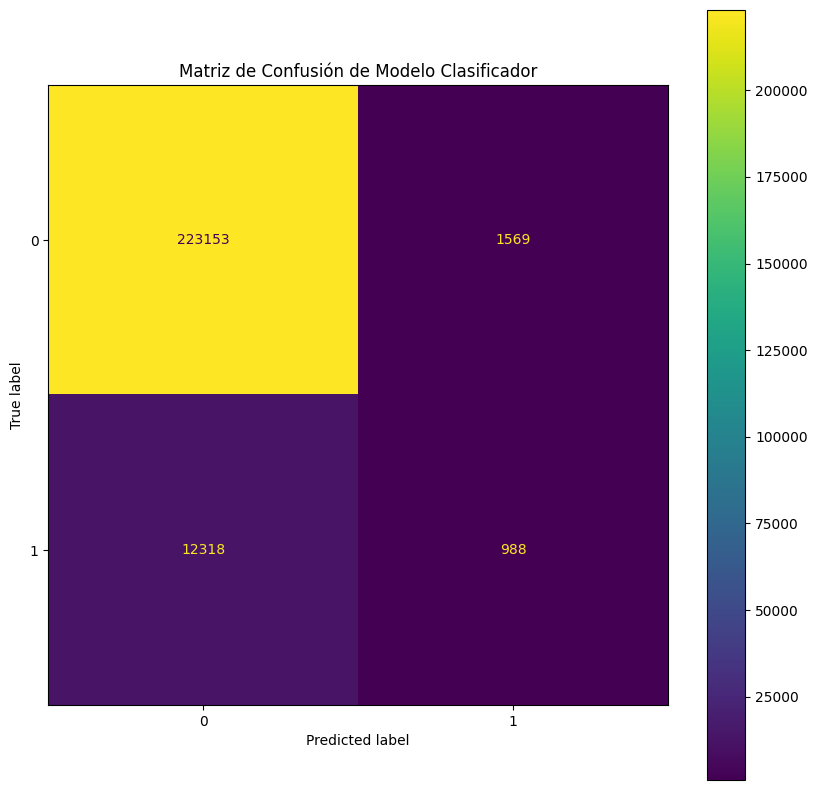

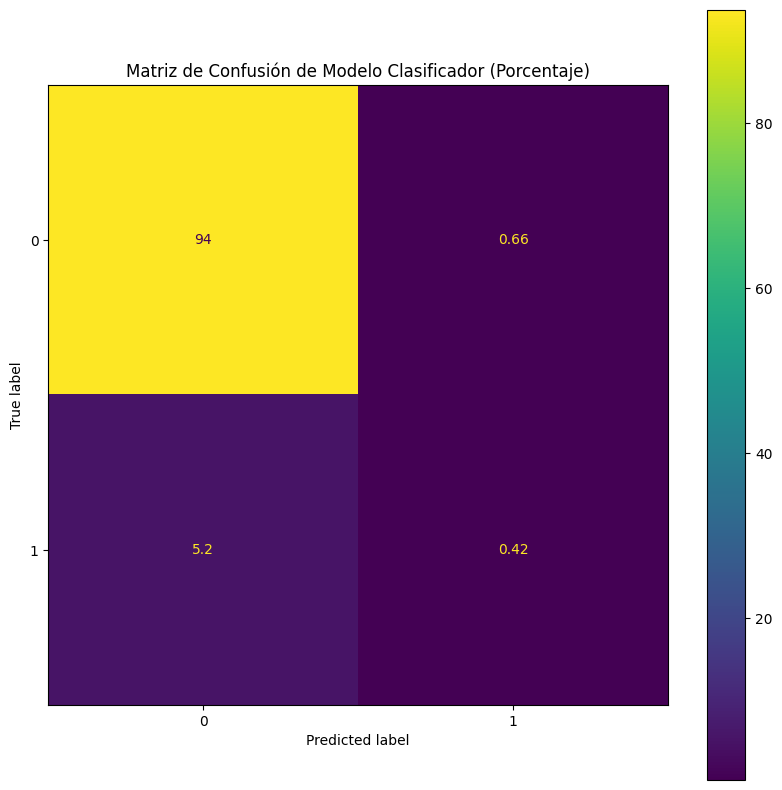

[[93.75073521  0.65916615]
 [ 5.17502143  0.41507722]]
Accuracy: 0.9416581242542894
Precision: 0.9416581242542894
Recall: 0.9416581242542894
F1 Score: 0.9416581242542894
--------------------------------------------------------------
----------------------------TRAIN------------------------------


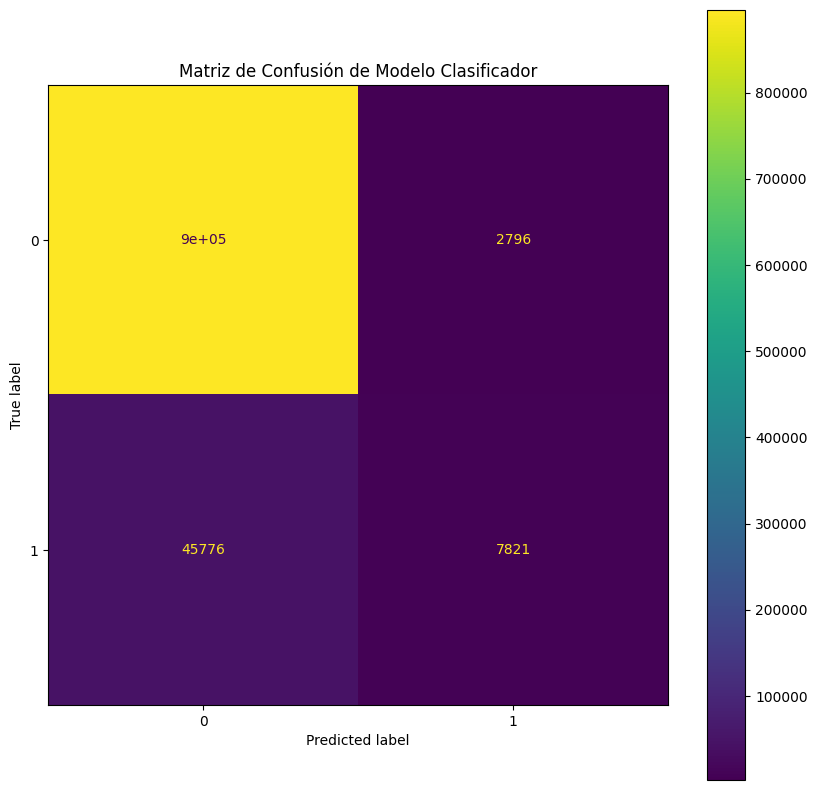

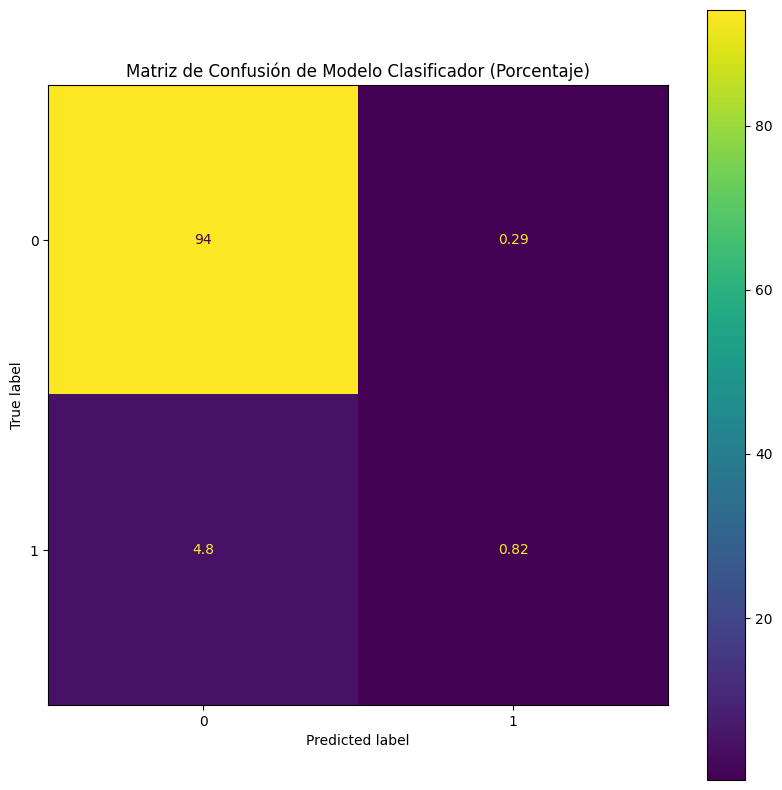

[[94.0770437   0.29366386]
 [ 4.80785288  0.82143956]]
Accuracy: 0.9489848326189544
Precision: 0.9489848326189544
Recall: 0.9489848326189544
F1 Score: 0.9489848326189544


RandomForestClassifier(max_depth=30, n_estimators=300, random_state=42)

In [13]:
classificationRandomForest(X_train, y_train, X_test, y_test)

In [67]:
# Aplicar RandomUnderSampler a tus datos
X_resampled, y_resampled = rus.fit_resample(X, y)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento: (1001417, 5)
Tamaño del conjunto de prueba: (250355, 5)


In [69]:
# Hacer un Random Forest como clasificador
rfClass_model = RandomForestClassifier(random_state=42)
rfClass_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [74]:
max([estimator.tree_.max_depth for estimator in rfClass_model.estimators_])

55

Se tardo 11.432497999980114 segundos en predecir
--------------------------------------------------------------
----------------------------TEST------------------------------


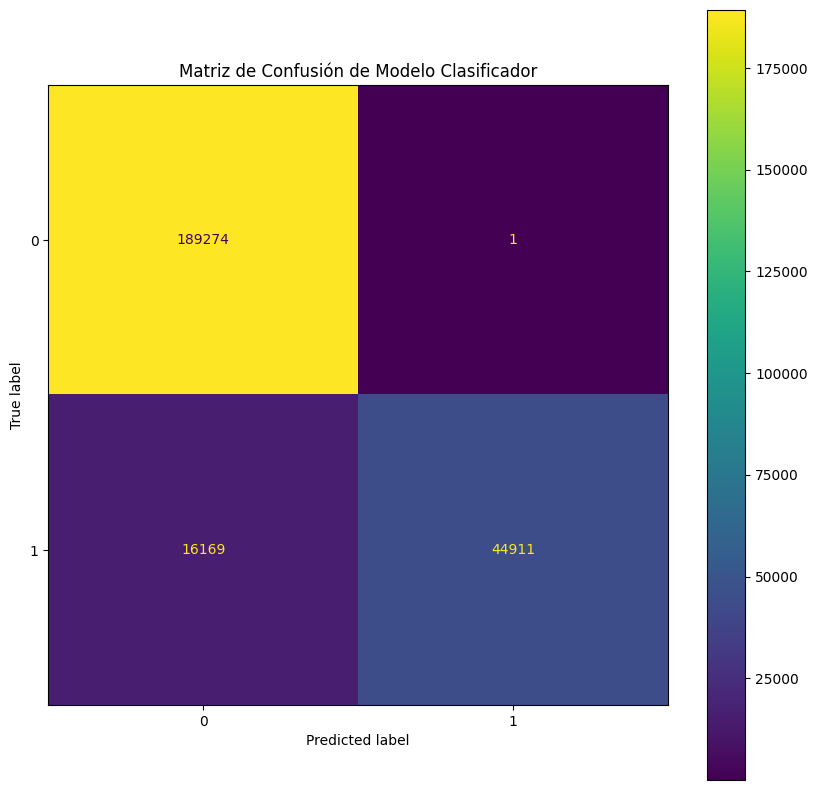

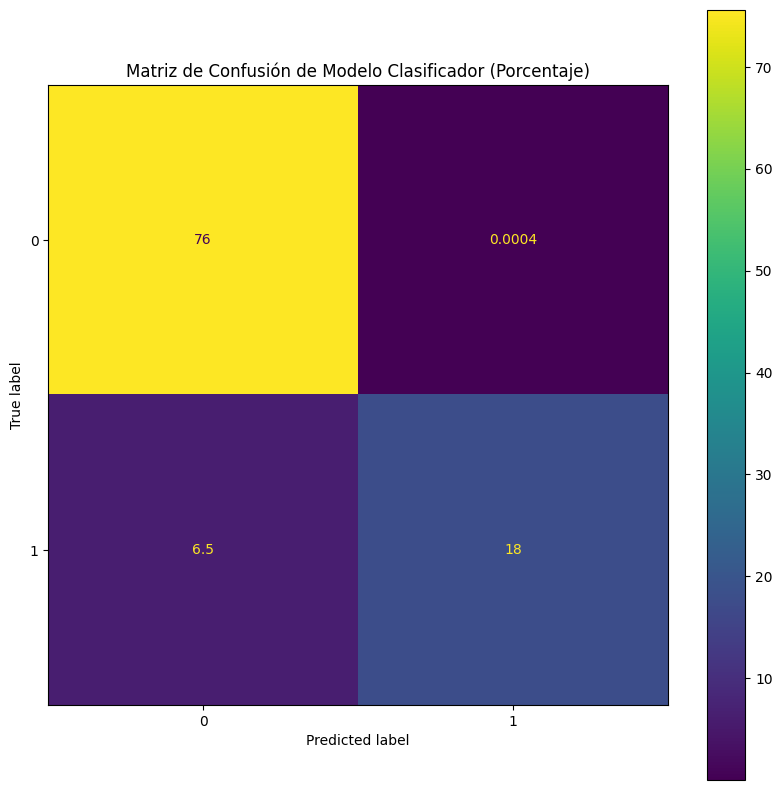

[[7.56022448e+01 3.99432805e-04]
 [6.45842903e+00 1.79389267e+01]]
Accuracy: 0.9354117153641829
Precision: 0.9354117153641829
Recall: 0.9354117153641829
F1 Score: 0.9354117153641829
--------------------------------------------------------------
----------------------------TRAIN------------------------------


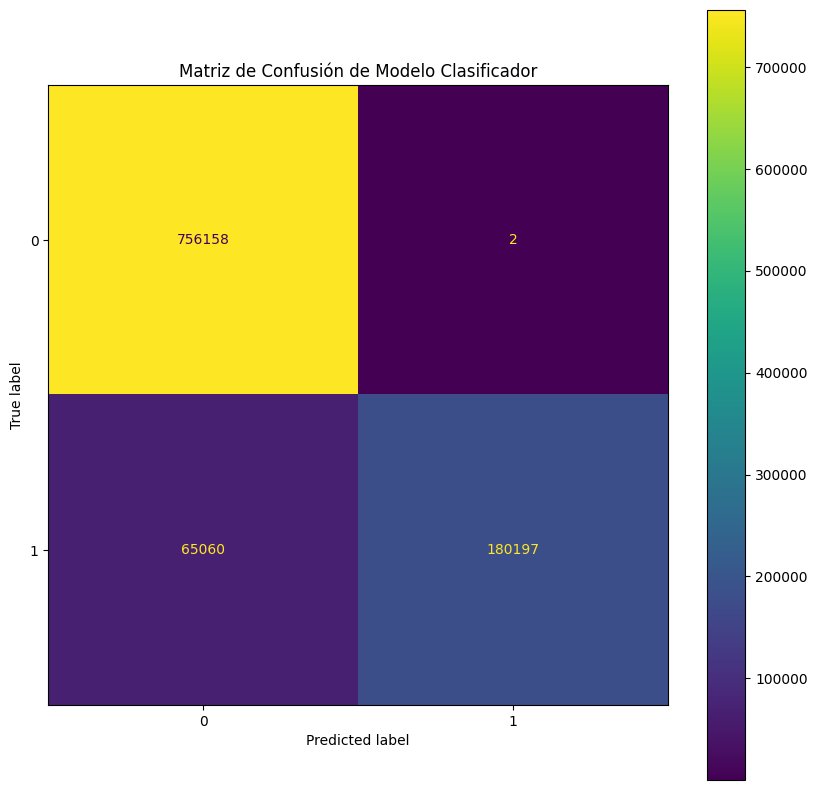

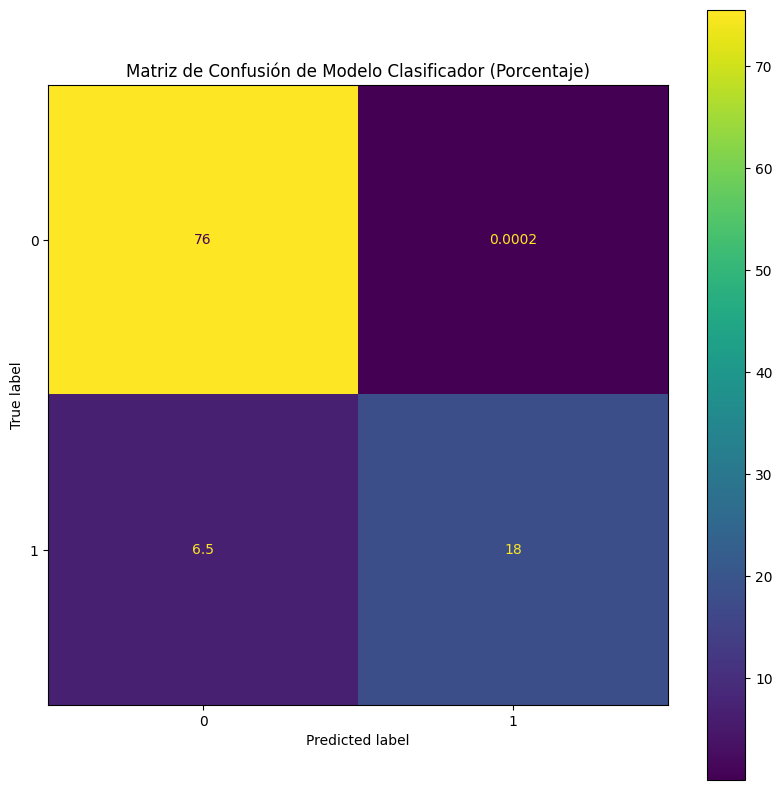

[[7.55088040e+01 1.99717001e-04]
 [6.49679404e+00 1.79942022e+01]]
Accuracy: 0.9350300624015769
Precision: 0.9350300624015769
Recall: 0.9350300624015769
F1 Score: 0.9350300624015769


In [83]:
clfMetrics(rfClass_model, X_test,X_train , y_test,y_train)

### Tuneamos el mejor modelo de clasificacion

Los mejores parametros {'max_depth': 40, 'n_estimators': 200}
Se tardo 16.91108059999533 segundos en predecir
--------------------------------------------------------------
----------------------------TEST------------------------------


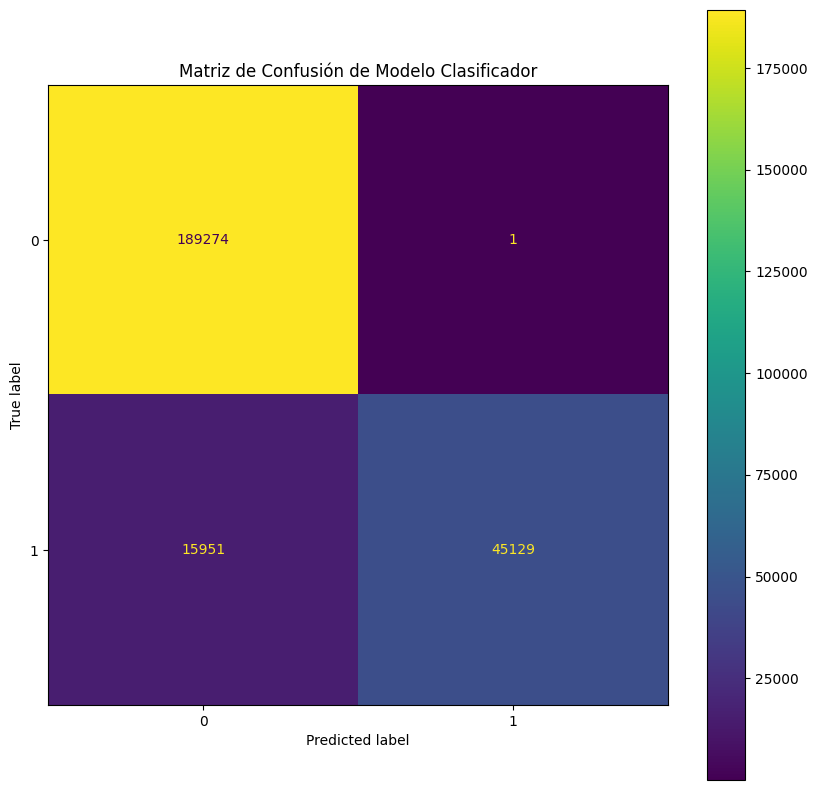

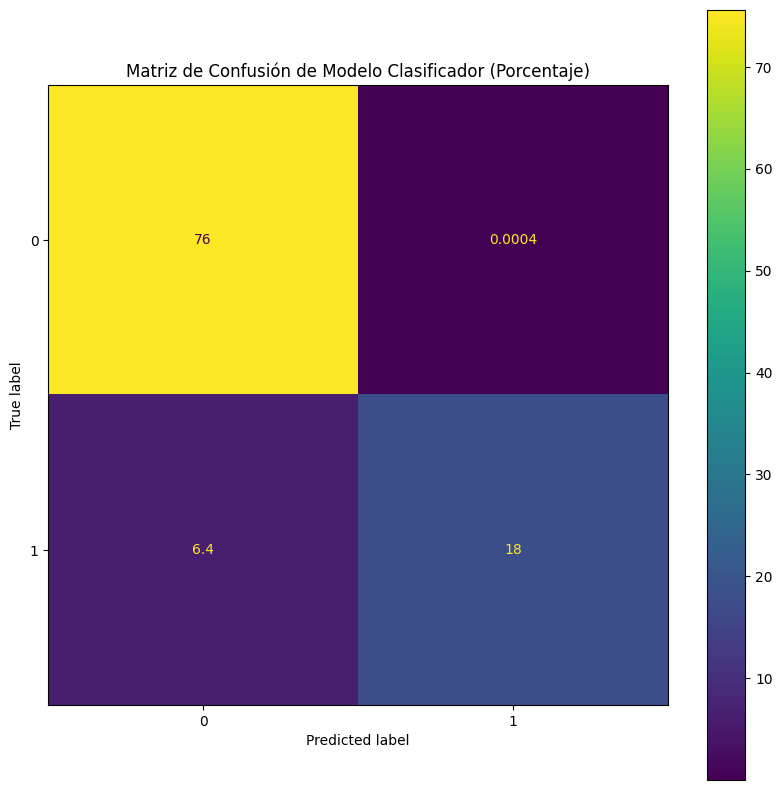

[[7.56022448e+01 3.99432805e-04]
 [6.37135268e+00 1.80260031e+01]]
Accuracy: 0.9362824788799904
Precision: 0.9362824788799904
Recall: 0.9362824788799904
F1 Score: 0.9362824788799904
--------------------------------------------------------------
----------------------------TRAIN------------------------------


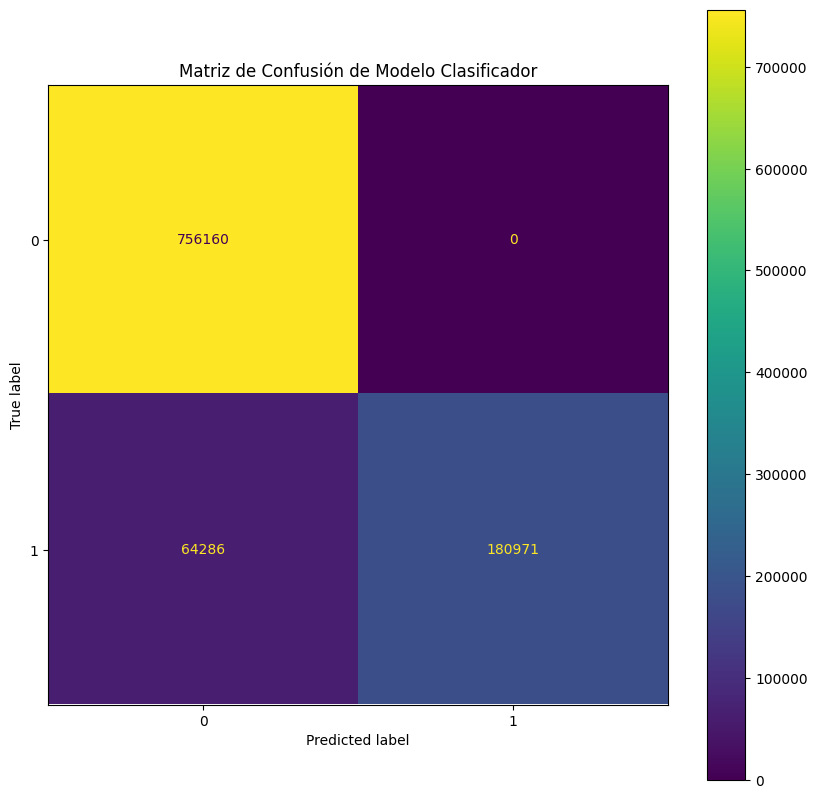

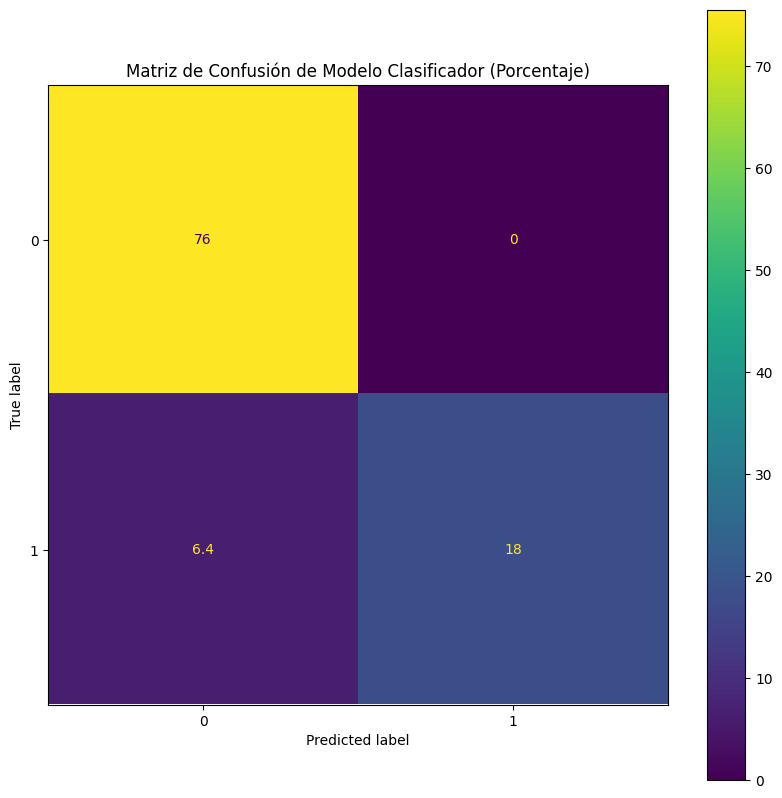

[[75.50900374  0.        ]
 [ 6.41950356 18.07149269]]
Accuracy: 0.9358049643654941
Precision: 0.9358049643654941
Recall: 0.9358049643654941
F1 Score: 0.9358049643654941


RandomForestClassifier(max_depth=40, n_estimators=200, random_state=42)

In [91]:
classificationRandomForest(X_train, y_train, X_test, y_test)

In [92]:
with open('X_resampled.pkl', 'wb') as f:
    pickle.dump(X_resampled, f)

In [93]:
with open('y_resampled.pkl', 'wb') as f:
    pickle.dump(y_resampled, f)